# NLP with Logistic Regression
### Case Study: Disaster Tweet Identification
In this notebook, we will walk through Natural Language Processing with Classification and Vector Spaces. Today, we will predict real disaster from given tweet using Logistc Regression and basic text processing. Objective of this notebook is to get familiar with Logistic Regression and how we can do natural language processing. I hope that this notebook will be useful to people who start learning natural language processing and text classification. Let's get started :)

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
KAGGLE_HOME = '../input/nlp-getting-started'

tweets = pd.read_csv('train.csv')
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Cleaning and Text Processing
Before we get started, we will remove unnecessary part in tweet as below:
- **Remove stopwords**
- **Remove punctuation**
- **Remove url**

In [8]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

URL_PATTERN = '((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*'
all_stopwords = stopwords.words('english')

def process_text(text):
    # remove stopwords
    remove_stop = ' '.join([word for word in text.split() if word not in all_stopwords])
    remove_url = re.sub(URL_PATTERN, '', remove_stop)
    remove_punc = re.sub(r'[^\w\s]', '', remove_url)
    
    return remove_punc.lower()

tweets['processed_text'] = tweets['text'].apply(lambda text: process_text(text))

print(f'\nBefore text processing: \n{tweets.text[100]}')
print(f'\nAfter text processing: \n{process_text(tweets.text[100])}')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\R.Sujith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Before text processing: 
.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad

After text processing: 
norwaymfa bahrain police previously died road accident killed explosion 


In [9]:
from collections import defaultdict

# create generating word frequency dictionary
def create_word_index(string):
    freq_dict = defaultdict(int)
    
    for word in string.split():
        if word not in freq_dict:
            freq_dict[word] = 1
        else:
            freq_dict[word] += 1
    
    return freq_dict

positive_corpus = ' '.join(text for text in tweets[tweets['target'] == 1]['processed_text'])
negative_corpus = ' '.join(text for text in tweets[tweets['target'] == 0]['processed_text'])

pos_freq_dict = create_word_index(positive_corpus)
neg_freq_dict = create_word_index(negative_corpus)

# create map function to map sum of frequency of each tweets
def extract_features(freq_dict, tweet):
    freq = 0
    
    for word in tweet.split():
        freq += freq_dict[word]
        
    return freq

tweets['pos_freq'] = tweets['processed_text'].apply(lambda tweet: extract_features(pos_freq_dict, tweet))
tweets['neg_freq'] = tweets['processed_text'].apply(lambda tweet: extract_features(neg_freq_dict, tweet))

tweets.head()

,id,keyword,location,text,target,processed_text,pos_freq,neg_freq
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds reason earthquake may allah forgive us,208,154
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,307,100
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked shelter place notified off...,177,143
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,282,109
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo ruby alaska smoke wildfire...,132,226


In [10]:
from collections import defaultdict

# create generating word frequency dictionary
def create_word_index(string):
    freq_dict = defaultdict(int)
    
    for word in string.split():
        if word not in freq_dict:
            freq_dict[word] = 1
        else:
            freq_dict[word] += 1
    
    return freq_dict

positive_corpus = ' '.join(text for text in tweets[tweets['target'] == 1]['processed_text'])
negative_corpus = ' '.join(text for text in tweets[tweets['target'] == 0]['processed_text'])

pos_freq_dict = create_word_index(positive_corpus)
neg_freq_dict = create_word_index(negative_corpus)

# create map function to map sum of frequency of each tweets
def extract_features(freq_dict, tweet):
    freq = 0
    
    for word in tweet.split():
        freq += freq_dict[word]
        
    return freq

tweets['pos_freq'] = tweets['processed_text'].apply(lambda tweet: extract_features(pos_freq_dict, tweet))
tweets['neg_freq'] = tweets['processed_text'].apply(lambda tweet: extract_features(neg_freq_dict, tweet))

tweets.head()

,id,keyword,location,text,target,processed_text,pos_freq,neg_freq
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds reason earthquake may allah forgive us,208,154
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,307,100
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked shelter place notified off...,177,143
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,282,109
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo ruby alaska smoke wildfire...,132,226


# Split data to train set and validation set
In this section, we will split data into train and validation set with .8 split size.
<br/> **Let's practice with our own split function !!!**

In [11]:
def split_train_test(features, labels, split_size):
    train_size = int(len(features) * split_size)
    
    data = list(zip(features, labels))
    shuffle_data = random.sample(data, len(data))
    
    shuffle_features = [feature for feature, label in shuffle_data]
    shuffle_labels = [label for feature, label in shuffle_data]
    
    x_train = np.array(shuffle_features[:train_size])
    y_train = np.array(shuffle_labels[:train_size]).reshape((len(shuffle_labels[:train_size]), 1))
    
    x_test = np.array(shuffle_features[train_size:])
    y_test = np.array(shuffle_labels[train_size:]).reshape((len(shuffle_labels[train_size:]), 1))
    
    return x_train, x_test, y_train, y_test

# split training and testing data to 80:20
#tweets_text = tweets.copy().pop('processed_text').values
#labels = tweets.copy().pop('target').values

#X_train, X_test, y_train, y_test = split_train_test(tweets_text, labels, 0.8)

# Implementing Logistic Regression from scratch
In this section, we will implement **Logistic Regression** to predict whether tweet is real disaster or not. However, we will not implement logistic regession using machine learning library, for example, scikit-learn and statsmodels. As we will learn to implement logistic regression from scratch, we will implement it by using custom logistic regression function.
**<br/> Let's get started how we can implement logistic regression !!!**

<AxesSubplot:xlabel='norm_pos_freq', ylabel='norm_neg_freq'>

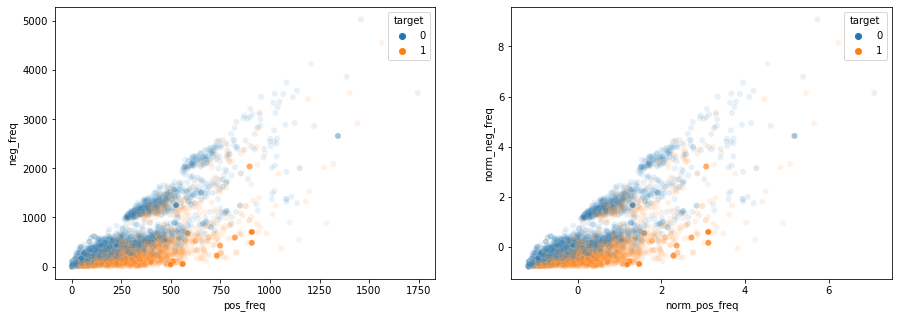

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# log transformation
# tweets['log_pos_freq'] = np.log(tweets['pos_freq'])
# tweets['log_neg_freq'] = np.log(tweets['neg_freq'])

# normalization
tweets['norm_pos_freq'] = (tweets['pos_freq'] - tweets['pos_freq'].mean()) / tweets['pos_freq'].std()
tweets['norm_neg_freq'] = (tweets['neg_freq'] - tweets['neg_freq'].mean()) / tweets['neg_freq'].std()

fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
sns.scatterplot(
    x = 'pos_freq', y = 'neg_freq', hue = 'target', data = tweets, 
    ax = axes[0], alpha = 0.1
)

sns.scatterplot(
    x = 'norm_pos_freq', y = 'norm_neg_freq', hue = 'target', data = tweets, 
    ax = axes[1], alpha = 0.1
)

## Custom Logistic Regression
In this section, we will create custom Logistic Regression
<br/> Five step of Logistic Regression
<br/> **Step 1:** Initialize parameters
<br/> **Step 2:** Classify/predict
<br/> **Step 3:** Compute gradient
<br/> **Step 4:** Update parameter
<br/> **Step 5:** Compute loss
<br/> After complete five steps, repeat step 2 through step 5 until we get minimize loss and maximum accuracy

In [15]:
# Custom logistic regression
class LogisticRegression:
    def __init__(self):
        weight = None
        costs = []
        accuracies = []
        
    def sigmoid(self, x):
        output = 1 / (1 + np.exp(-x))
        return output
        
    def compute_cost(self, y_pred, y):
        error = (y *  np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        return -np.mean(error)
    
    def compute_gradient(self, X, y, y_pred):
        gradient = (1/len(X)) * np.dot(X.T, (y_pred - y))
        return gradient
    
    def fit(self, X, y, epoch, learning_rate):
        # initialize weight
        self.weight = np.zeros((X.shape[1], 1))

        # append cost hand accuracy istory
        costs = []
        accuracies= []
        
        for _ in tqdm(range(epoch)):
            y_pred = self.sigmoid(np.dot(X, self.weight))
            
            cost = self.compute_cost(y_pred, y)
            gradient = self.compute_gradient(X, y, y_pred)
            
            self.weight -= learning_rate * gradient 
            #self.bias -= learning_rate * gradient
            
            accuracy = self.score(X, y)
            
            costs.append(cost)
            accuracies.append(accuracy)
    
            
        self.costs = costs
        self.accuracies = accuracies
    
    def predict(self, X):
        y_pred = self.sigmoid(np.dot(X, self.weight))
        return y_pred > 0.5
    
    def predict_prob(self, X):
        y_prob = self.sigmoid(np.dot(X, self.weight))
        return y_prob
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

## Start Training Logistic Regression !!!

In [16]:
# Normalization
EPOCH = 500
LEARNING_RATE = 1

tweets_text = tweets[['pos_freq', 'neg_freq']].values

# compute mean and standard deviation of each column
mean = np.mean(tweets_text, axis = 0)
std = np.std(tweets_text, axis = 0)

# normalize feature (x - mean) / sd
tweets_text = (tweets_text - mean) / std
labels = tweets.copy().pop('target').values

X_train, X_test, y_train, y_test = split_train_test(tweets_text, labels, 0.8)

# Add intercept term: [bias w_1 w_2]
X_train = np.append(np.ones((X_train.shape[0], 1)), X_train, axis = 1)
X_test = np.append(np.ones((X_test.shape[0], 1)), X_test, axis = 1)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train, EPOCH, LEARNING_RATE)

print(f'Optimized parameters: \n{log_reg.weight}')
print(f'Loss: {log_reg.costs[-1]}')
print(f'Test Accuracy: {log_reg.score(X_test, y_test)}')

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2178.48it/s]

Optimized parameters: 
[[-0.33106933]
 [ 2.13768174]
 [-2.38209971]]
Loss: 0.5231540058649935
Test Accuracy: 0.7360472751149048


Text(0.5, 1.0, 'Accuracy')

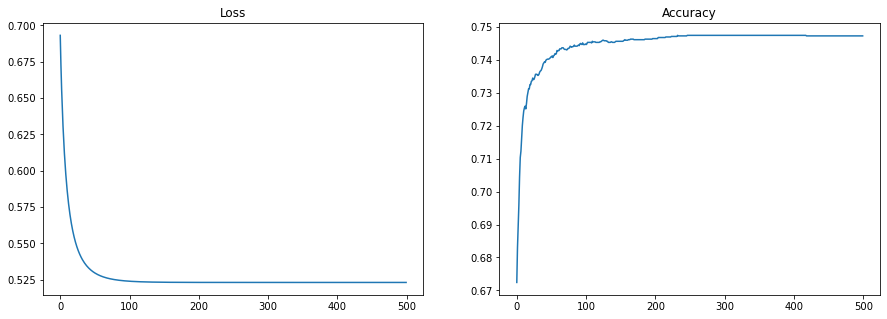

In [17]:
fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))

loss_history = log_reg.costs
accuracy_history = log_reg.accuracies

axes[0].plot(range(EPOCH), loss_history)
axes[0].set_title('Loss')

axes[1].plot(range(EPOCH), accuracy_history)
axes[1].set_title('Accuracy')

# Decision Boundary
In this section, we will draw decision boundary to visualize the line that separate two classes

<AxesSubplot:title={'center':'Decision Boundary'}, xlabel='Negative Frequency', ylabel='Positive Frequency'>

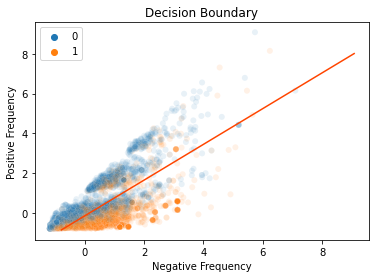

In [18]:
ax = sns.scatterplot(
    x = 'norm_pos_freq', y = 'norm_neg_freq', hue = 'target',
    data = tweets, alpha = 0.1
)

ax.legend([1, 0])
ax.set_xlabel('Negative Frequency')
ax.set_ylabel('Positive Frequency')
ax.set_title('Decision Boundary')

# theta_0 + theta_1 * pos_freq + theta_2 * neg_freq = 0
# pos_freq = -(theta_0 + theta_2 * neg_freq) / theta_1

x_bound = np.array([np.min(tweets_text[:, 1]), np.max(tweets_text[:, 1])])
y_bound = -(log_reg.weight[0] + log_reg.weight[1] * x_bound) / log_reg.weight[2]

sns.lineplot(
    x = x_bound, y = y_bound, 
    color = 'orangered'
)

# Tuning Learning Rate 
In this notebook, I set learning rate to 1. Learning rate is the hyperparameter that control how much to change model parameters, so you can try different learning rate and select leaning rate that make loss level-off without a huge number of iterations.

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2048.60it/s]


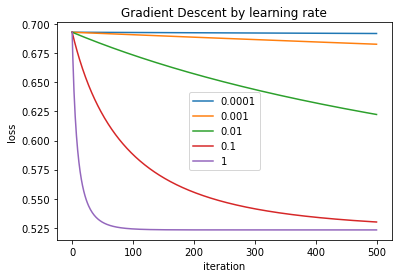

In [19]:
learning_rates = {0.0001: [], 0.001: [], 0.01: [], 0.1: [], 1: []}

for lr in learning_rates.keys():
    model = LogisticRegression()
    model.fit(X_train, y_train, EPOCH, lr)
    learning_rates[lr] += model.costs


for lr in learning_rates.keys():
    plt.plot(range(EPOCH), learning_rates[lr])

plt.title('Gradient Descent by learning rate')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(learning_rates.keys())

# Model Evaluation and ROC Curve

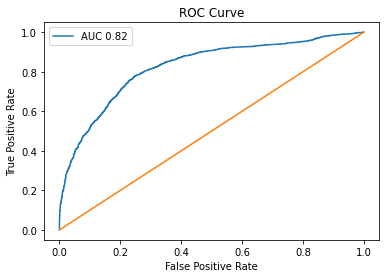

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = log_reg.predict_prob(X_train)

fpr, tpr, threshold = roc_curve(y_train, y_prob)
roc_auc = roc_auc_score(y_train, y_prob)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label = "AUC %.2f" %roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [21]:
# F1 Score
# 2 * (Precision * Recall) / (Precision + Recall)
# Precision = tp / (tp + fp)

def f1_score(y, y_pred):
    tp = np.sum((y == 1) & (y_pred == 1))
    fp = np.sum((y == 0) & (y_pred == 1))
    fn = np.sum((y == 1) & (y_pred == 0))
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return f1

y_pred = log_reg.predict(X_train)
y_prob = log_reg.predict_prob(X_train)
val_prob = log_reg.predict_prob(X_test)

# print(pd.crosstab(np.array(y_train).reshape(-1), np.array(y_pred).reshape(-1)))
print(f'Training F1 Score: {f1_score(y_train, y_prob >= 0.4)}')
print(f'Validation F1 Score: {f1_score(y_test, val_prob >= 0.4)}')

Training F1 Score: 0.732676945940925
Validation F1 Score: 0.7274085138162807


## Create Submission
In this section, we will process unseen data with predefined function.
<br/> **Now we're done and ready to make a submission !!!**
<br/> My submission show 73.58% accuracy on unseen data. Our custom model is not so good but not bad!!! 
<br/> I hope all beginners like me will enjoy learning my notebook. Thanks :)

In [25]:
test_data = pd.read_csv('test.csv')
test_data['processed_tweets'] = test_data['text'].apply(lambda tweet: process_text(tweet))
test_data['pos_freq'] = test_data['processed_tweets'].apply(lambda tweet: extract_features(pos_freq_dict, tweet))
test_data['neg_freq'] = test_data['processed_tweets'].apply(lambda tweet: extract_features(neg_freq_dict, tweet))

features = test_data[['pos_freq', 'neg_freq']].values

# normalize data
features_mean = np.mean(features, axis = 0)
features_std = np.std(features, axis = 0)
features = (features - features_mean) / features_std
features = np.append(np.ones((features.shape[0], 1)), features, axis = 1)

submission_prediction = log_reg.predict_prob(features)
submission_prediction = [1 if p >= 0.35 else 0 for p in submission_prediction]
test_data['target'] = submission_prediction

#test_data[['id', 'target']].to_csv('submission.csv', index = False)